In [ ]:
#|default_exp n3c1_training_aes_on_branches
import numpy as np
import matplotlib.pyplot as plt
import deepdish

import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"

# models
import torch
from autometric.autoencoders import DistanceMatchingAutoencoder
from autometric.datasets import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

# 2a1 Training Example

First, we need `X` and `D`, the points and their distances -- however we choose to compute them!

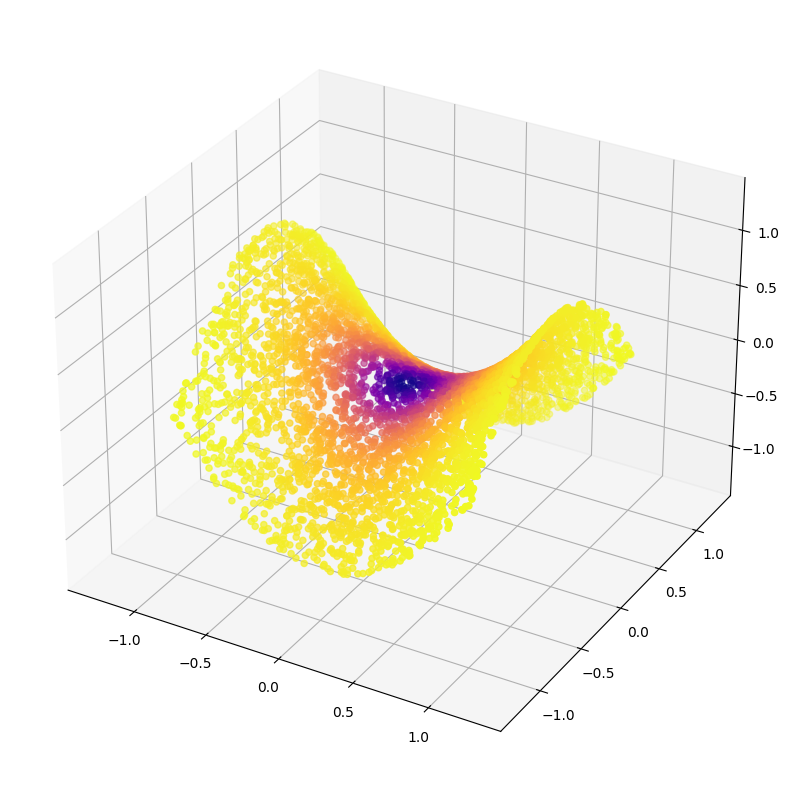

In [ ]:
from autometric.datasets import paraboloid
from diffusion_curvature.utils import plot_3d
X, ks = paraboloid(5000)
plot_3d(X, ks)

We'll use the phate distances here:

Computing PHATE with phate_decay=40 and n_neighbors=15
Calculating PHATE...
  Running PHATE on 5000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...


    Calculated KNN search in 0.08 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.14 seconds.
    Calculating KMeans...
    Calculated KMeans in 0.91 seconds.
  Calculated landmark operator in 1.53 seconds.
  Calculating optimal t...
    Automatically selected t = 39
  Calculated optimal t in 0.44 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.65 seconds.
Calculated PHATE in 4.96 seconds.


/tmp/ipykernel_3407861/382268582.py:11: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(phate_coords, c=ks)


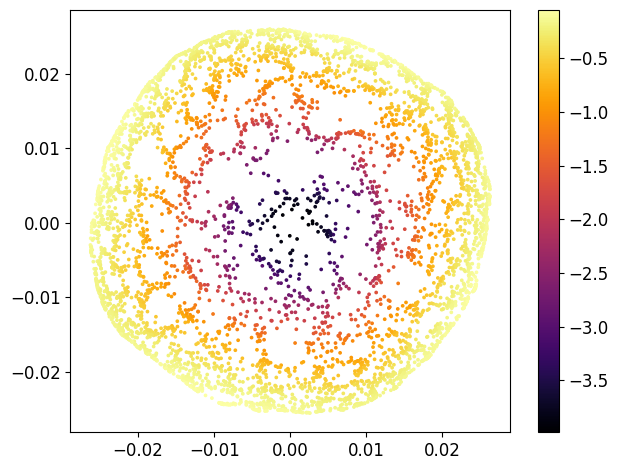

In [ ]:
import phate
# PHATE's parameters
phate_decay = 40
n_neighbors = 15
phate_gamma = 1
phate_knn = 15

print(f"Computing PHATE with {phate_decay=} and {n_neighbors=}")
phate_op = phate.PHATE(gamma=phate_gamma, knn=phate_knn, random_state=42) #n_components = 2, decay=phate_decay, knn=self.n_neighbors
phate_coords = phate_op.fit_transform(X)
phate.plot.scatter2d(phate_coords, c=ks)
phate_coords = torch.tensor(phate_coords)
phate_D = torch.cdist(phate_coords, phate_coords).detach()


In [ ]:
from autometric.autoencoders import DistanceMatchingAutoencoder
from autometric.datasets import train_and_testloader_from_pointcloud_with_distances
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

model_filename = "paraboloid_encoder.pt"

# Create dataloaders
trainloader, testloader = train_and_testloader_from_pointcloud_with_distances(
    X, # <---- Pointcloud
    phate_D, # <---- Distance matrix to match
    batch_size=64)
train_sample = next(iter(trainloader))

# Initialize model and trainer
model = DistanceMatchingAutoencoder(
    input_dim = train_sample['x'].shape[1],
    intrinsic_dim = 2,
    reconstruction_weight = 1,
    distance_weight = 1,
    )
early_stopping = EarlyStopping('val_loss', patience=500)
trainer = Trainer(
    max_epochs=1000, 
    accelerator='cuda',
    callbacks=[early_stopping],
    use_distributed_sampler=False
    )

if os.path.exists(f'../data/{model}'):
    model.load_state_dict(torch.load(f'../data/{model_filename}'))
else:
    trainer.fit(
        model=model,
        train_dataloaders=trainloader,
        val_dataloaders=testloader,
    )

/home/piriac/Pumberton/Workshop/23-Geometric-AE/autometric/autometric/datasets.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.distances = torch.tensor(distances, dtype=torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 42.3 K
1 | decoder | Sequential | 42.3 K
---------------------------------------
84.6 K    Trainable params
0         Non-trainable params
84.6 K    Total params
0.338     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/piriac/mambaforge/envs/autometric/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]